## This notebook serves two purposes:
1. Download the 80/20 split of data by downloading the corresponding images and labels directly.
2. Train the data on the YOLOv8m and YOLOv11L models.


### Downloading the Images and Labels:

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 41.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
import kagglehub
from pycocotools.coco import COCO
import torch
from torchvision.transforms import functional as F
from PIL import Image
import requests
from tqdm.notebook import tqdm


In [ ]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
fathomnet_out_of_sample_detection_path = kagglehub.competition_download('fathomnet-out-of-sample-detection')
fathomnet_install_dir = os.path.join(os.getcwd(), fathomnet_out_of_sample_detection_path)
print('Data source import complete.')

destination_folder = "/content/drive/MyDrive/"
shutil.move(fathomnet_install_dir, destination_folder) if not os.path.exists(os.path.join(destination_folder, 'fathomnet-out-of-sample-detection')) else None
print(f"Dataset moved to {destination_folder}")

# List the contents of the directory
fathomnet_path = os.path.join(destination_folder, "fathomnet-out-of-sample-detection")
print(fathomnet_path)
directory_contents = os.listdir(fathomnet_path+'/object_detection')
print(f"Directory contents: {directory_contents}")


100%|██████████| 1.30M/1.30M [00:00<00:00, 134MB/s]

Extracting files...
Data source import complete.
Dataset moved to /content/drive/MyDrive/
/content/drive/MyDrive/fathomnet-out-of-sample-detection


Directory contents: ['train.json', 'eval.json']


In [ ]:
import json
train_json_path = os.path.join(fathomnet_path, 'object_detection/train.json')
eval_json_path = os.path.join(fathomnet_path, 'object_detection/eval.json')

def read_json_file(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        if "images" in data:
            return data, len(data["images"])
        elif isinstance(data, dict):
            return data, len(data)
        elif isinstance(data, list):
            return data, len(data)
        else:
            return -1
    except FileNotFoundError:
        print(f"{json_path} not found.")
        return None, -1
    except json.JSONDecodeError:
        print(f"Error decoding JSON in {json_path}.")
        return None, -1

train_data, train_entry_count = read_json_file(train_json_path)
eval_data, eval_entry_count = read_json_file(eval_json_path)

print(f"Number of images in train.json: {train_entry_count}")
print(f"Number of images in eval.json: {eval_entry_count}")


Number of images in train.json: 5950
Number of images in eval.json: 10744


In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for COCO format.
    Handles loading images and annotations for YOLO-style processing.
    """
    def __init__(self, json_file, img_dir, sample_size, transforms=None):
        """
        Initialize the dataset with a COCO JSON file and image directory.

        Args:
            json_file (str): Path to COCO JSON file.
            img_dir (str): Path to the directory containing images.
            sample_size (int): Number of samples to use from the dataset.
            transforms: Optional transformations to apply to the images.
        """
        self.coco = COCO(json_file)
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = self.coco.getImgIds()[:sample_size]  # Limit to `sample_size`

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


### Here, we set up the 80/20 split.

In [ ]:
# Define parameters
sample_size = 5950
split_ratio = 0.8
split_index = int(sample_size * split_ratio)

# Define paths for train and test images
fathomnet_train_img_path = os.path.join(fathomnet_path, "train/images")
fathomnet_test_img_path = os.path.join(fathomnet_path, "val/images")

os.makedirs(fathomnet_train_img_path, exist_ok=True)
os.makedirs(fathomnet_test_img_path, exist_ok=True)

# Initialize the dataset
dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_train_img_path, sample_size=sample_size)

# Split dataset into train and test
train_ids = dataset.image_ids[:split_index]
test_ids = dataset.image_ids[split_index:]

# Train and test datasets
train_dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_train_img_path, sample_size=split_index)
test_dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_test_img_path, sample_size=sample_size - split_index)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Train samples: 4760
Test samples: 1190


In [ ]:
len(train_dataset), len(test_dataset )

(4760, 1190)

Now, we download the corresponding images.

In [ ]:
def download_images(dataset, img_dir):
    """
    Downloads images for the given dataset.

    Args:
        dataset: Dataset containing image IDs.
        img_dir: Directory to save downloaded images.
    """
    for img_info in tqdm(dataset.coco.loadImgs(dataset.image_ids), desc="Downloading Images"):
        img_url = img_info.get("coco_url")
        img_filename = os.path.join(img_dir, img_info["file_name"])

        if not os.path.exists(img_filename):
            try:
                response = requests.get(img_url, stream=True)
                response.raise_for_status()
                with open(img_filename, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        f.write(chunk)
            except Exception as e:
                print(f"Failed to download {img_url}: {e}")

download_images(train_dataset, fathomnet_train_img_path)
download_images(test_dataset, fathomnet_test_img_path)

Next, we download the corresponding labels.

In [ ]:
def convert_annotations(dataset, annotation_dir):
    """
    Converts COCO-style annotations to YOLO format and saves them.

    Args:
        dataset: Dataset containing image and annotation data.
        annotation_dir: Directory to save YOLO-format annotation files.
    """
    os.makedirs(annotation_dir, exist_ok=True)
    for img_id in tqdm(dataset.image_ids, desc="Processing Annotations"):
        img_info = dataset.coco.loadImgs(img_id)[0]
        img_filename = img_info["file_name"]
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
        anns = dataset.coco.loadAnns(ann_ids)

        label_file = os.path.join(annotation_dir, os.path.splitext(img_filename)[0] + ".txt")
        if os.path.exists(label_file):
            continue

        with open(label_file, "w") as f:
            for ann in anns:
                bbox = ann["bbox"]
                category_id = ann["category_id"] - 1  # YOLO expects 0-indexed classes

                # Convert COCO bbox format to YOLO format
                x_center = (bbox[0] + bbox[2] / 2) / img_info["width"]
                y_center = (bbox[1] + bbox[3] / 2) / img_info["height"]
                width = bbox[2] / img_info["width"]
                height = bbox[3] / img_info["height"]

                f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

# Prepare annotations for train and test datasets
train_annotation_dir = os.path.join(fathomnet_path, "train/labels")
test_annotation_dir = os.path.join(fathomnet_path, "val/labels")
convert_annotations(train_dataset, train_annotation_dir)
convert_annotations(test_dataset, test_annotation_dir)


Processing Annotations:   0%|          | 0/4760 [00:00<?, ?it/s]

Processing Annotations:   0%|          | 0/1190 [00:00<?, ?it/s]

In [ ]:
import os

directory_path = '/content/drive/MyDrive/fathomnet-out-of-sample-detection/images'
all_files = os.listdir(directory_path)
image_files = [f for f in all_files if f.lower().endswith(('.png'))]
image_count = len(image_files)
print(f"Number of images in {directory_path}: {image_count}")


Number of images in /content/drive/MyDrive/fathomnet-out-of-sample-detection/val/labels: 1190


### Run YOLOv8m on 80/20 split with 200 epochs.

In [ ]:
import os
output_folder = "/content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs"

In [ ]:
from ultralytics import YOLO
# Load a pre-trained YOLOv11 model
model = YOLO("yolov8m.pt")  # Replace with yolov11s.pt, yolov11m.pt, etc., for larger models

# Train the model
model.train(
    data="/content/drive/MyDrive/fathomnet-out-of-sample-detection/dataset.yaml",
    epochs=200,
    patience=40,               # Stop if no improvement for 40 epochs (early stopping)
    batch=16,
    imgsz=640,
    name = 'yolov8m_resampled',
    project = output_folder,
    save=True,
    verbose=False
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 138MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/fathomnet-out-of-sample-detection/dataset.yaml, epochs=200, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs, name=yolov8m_resampled, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

100%|██████████| 755k/755k [00:00<00:00, 20.3MB/s]


Overriding model.yaml nc=80 with nc=290

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 84.5MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/train/labels... 4760 images, 0 backgrounds, 1 corrupt: 100%|██████████| 4760/4760 [01:11<00:00, 66.64it/s] 

train: WARNING ⚠️ /content/drive/MyDrive/fathomnet-out-of-sample-detection/train/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0446      1.0257]


train: New cache created: /content/drive/MyDrive/fathomnet-out-of-sample-detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/val/labels... 1190 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1190/1190 [00:17<00:00, 67.87it/s] 


val: New cache created: /content/drive/MyDrive/fathomnet-out-of-sample-detection/val/labels.cache
Plotting labels to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      7.84G      1.581      3.037      1.175         94        640: 100%|██████████| 298/298 [00:49<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  4.14it/s]


                   all       1190       6101      0.723     0.0669     0.0665     0.0402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      7.47G      1.484       1.94      1.119         61        640: 100%|██████████| 298/298 [00:46<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


                   all       1190       6101      0.478      0.119      0.113     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      7.79G      1.509      1.837      1.112         66        640: 100%|██████████| 298/298 [00:45<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


                   all       1190       6101      0.421      0.125      0.121      0.071

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      7.53G      1.526      1.724      1.127         91        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


                   all       1190       6101      0.361      0.159      0.132     0.0781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       7.8G      1.534      1.607      1.134         45        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


                   all       1190       6101      0.447      0.161      0.168     0.0964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200       7.6G      1.509      1.505      1.122         37        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.404      0.156      0.164     0.0971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       7.4G       1.51      1.489      1.121         42        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


                   all       1190       6101      0.593      0.136      0.193      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      7.54G      1.477      1.408      1.108         43        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


                   all       1190       6101      0.496      0.199        0.2      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      7.64G      1.474      1.378      1.112         86        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


                   all       1190       6101      0.511      0.204      0.228      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      7.74G      1.465      1.354      1.108         46        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


                   all       1190       6101       0.52      0.244      0.262      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      7.48G      1.454      1.301      1.097         26        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


                   all       1190       6101       0.48      0.245      0.262      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      7.54G      1.439      1.285      1.098         57        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


                   all       1190       6101      0.493      0.288      0.296      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      7.65G      1.438      1.258      1.099         26        640: 100%|██████████| 298/298 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


                   all       1190       6101      0.545       0.25      0.307      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      7.53G       1.43      1.247      1.086         38        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


                   all       1190       6101      0.548      0.249      0.309      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      7.65G      1.419      1.223       1.08         41        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


                   all       1190       6101      0.522      0.294      0.322      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      7.43G      1.402      1.189       1.08         30        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


                   all       1190       6101      0.661      0.271      0.356      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      7.75G      1.403      1.184      1.077         68        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


                   all       1190       6101      0.569      0.311      0.383      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      7.61G      1.398      1.152      1.075         24        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.587      0.301      0.367      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      7.69G      1.384      1.143      1.073         35        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.592      0.377      0.427      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      7.47G      1.386      1.135      1.071         65        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


                   all       1190       6101      0.655      0.327        0.4      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       7.7G      1.383      1.122      1.068         16        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


                   all       1190       6101      0.552      0.351      0.417      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      7.46G      1.366      1.101      1.069         54        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.631      0.333      0.433      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      7.68G      1.368      1.086      1.064         77        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


                   all       1190       6101      0.649       0.39       0.47       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      7.46G      1.362      1.084       1.06         68        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.673      0.352      0.457      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      7.75G      1.353      1.062      1.055         51        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.691      0.316      0.482      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      7.47G      1.354      1.064      1.062         73        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.44it/s]


                   all       1190       6101      0.682      0.359      0.501      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      7.69G      1.351      1.053       1.06         26        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


                   all       1190       6101       0.67      0.407      0.534      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      7.52G      1.337      1.027      1.049         41        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101      0.598      0.485      0.537      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      7.68G      1.337      1.017      1.049         50        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.567      0.478      0.539      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      7.47G      1.328      1.017      1.045         55        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


                   all       1190       6101      0.654      0.415      0.562      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      7.68G       1.33      1.018      1.048         91        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.628      0.463      0.599      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      7.37G      1.325     0.9983      1.045         81        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


                   all       1190       6101      0.702      0.419      0.559      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      7.85G      1.319     0.9827      1.047         68        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


                   all       1190       6101      0.661      0.482      0.621       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      7.74G      1.305     0.9727      1.044         30        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


                   all       1190       6101      0.658      0.489      0.604      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      7.65G      1.307      0.971      1.037         35        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


                   all       1190       6101      0.723      0.477       0.62      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      7.47G      1.292      0.953      1.034         54        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


                   all       1190       6101      0.588      0.565      0.613      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      7.69G      1.294     0.9482      1.036         28        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


                   all       1190       6101      0.654      0.524      0.648      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      7.54G      1.289     0.9479      1.035         28        640: 100%|██████████| 298/298 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.641      0.566      0.685       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       7.7G      1.279     0.9252       1.03         51        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.693      0.536      0.666      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      7.53G      1.284      0.922      1.028         62        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.705      0.553      0.653      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      7.69G      1.279     0.9254      1.028         46        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


                   all       1190       6101      0.698      0.545      0.683      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      7.47G      1.277     0.9123      1.026         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


                   all       1190       6101      0.666      0.594       0.69      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      7.69G      1.264     0.8992      1.025         58        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.596      0.657       0.71       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      7.46G       1.26     0.8919      1.024         43        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.718       0.59      0.713      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      7.46G       1.25     0.8745      1.024         48        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


                   all       1190       6101       0.66      0.643       0.72      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      7.78G       1.24     0.8594      1.016         48        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.684      0.634      0.728      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      7.64G      1.252     0.8706      1.016         59        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101      0.637      0.671      0.735      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      7.48G      1.239     0.8656      1.013         61        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.51it/s]


                   all       1190       6101      0.737      0.629       0.75      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      7.39G      1.234     0.8562      1.013         34        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


                   all       1190       6101      0.691      0.632      0.753      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      7.56G      1.227     0.8381      1.007         43        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


                   all       1190       6101      0.724      0.676      0.758      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      7.68G      1.228      0.839      1.009         89        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.44it/s]


                   all       1190       6101      0.699      0.669      0.762      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      7.75G      1.214     0.8467      1.012         70        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


                   all       1190       6101      0.762      0.642      0.767      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      7.65G      1.205     0.8228      1.006         51        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.729      0.666      0.784      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      7.47G       1.22     0.8231      1.007         34        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.743      0.681      0.803      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      7.69G      1.207     0.8035     0.9991        133        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


                   all       1190       6101      0.709      0.719      0.805      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      7.49G      1.198     0.7982     0.9989         97        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


                   all       1190       6101      0.772      0.692      0.828      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      7.59G      1.181     0.7882     0.9933         63        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.48it/s]


                   all       1190       6101      0.782      0.664      0.811      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      7.79G      1.186     0.7854      0.995         59        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.811      0.652      0.803      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      7.68G      1.182     0.7805     0.9923         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


                   all       1190       6101      0.802      0.676      0.821      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      7.52G      1.173     0.7813     0.9889         31        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


                   all       1190       6101      0.768      0.713      0.826      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       7.7G      1.165     0.7658     0.9866         48        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


                   all       1190       6101       0.83       0.66      0.845      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      7.46G      1.174     0.7713     0.9886         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.768      0.749      0.834      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      7.69G      1.155     0.7592      0.983         76        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.754      0.747      0.847      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      7.47G      1.151     0.7459     0.9789         53        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


                   all       1190       6101       0.71      0.804      0.862      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      7.68G      1.141     0.7368     0.9799         41        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


                   all       1190       6101      0.747      0.755      0.857      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      7.54G      1.144      0.736     0.9831         50        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.847      0.731      0.874      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      7.75G      1.136     0.7342     0.9807         70        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


                   all       1190       6101      0.829      0.761      0.882       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      7.46G      1.134     0.7297     0.9773         48        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


                   all       1190       6101       0.83      0.726      0.879      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      7.45G       1.13     0.7242     0.9786         40        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


                   all       1190       6101      0.831      0.743       0.86      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      7.78G      1.117     0.7184     0.9742         32        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.838      0.745        0.9      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      7.64G      1.117     0.7101     0.9731         25        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.846      0.753      0.906      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      7.43G      1.107     0.7026     0.9681         68        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.839      0.787      0.905      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      7.69G      1.097     0.6887     0.9647         60        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


                   all       1190       6101      0.818      0.794      0.913      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      7.54G      1.099     0.6905     0.9681         79        640: 100%|██████████| 298/298 [00:45<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.852      0.773      0.906      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      7.74G      1.086     0.6819      0.963         52        640: 100%|██████████| 298/298 [00:45<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.859       0.77       0.91      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      7.54G      1.086     0.6817     0.9599         51        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


                   all       1190       6101      0.876      0.765      0.902      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      7.69G      1.084     0.6704     0.9626         66        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


                   all       1190       6101      0.866      0.791      0.905      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      7.48G      1.077     0.6668     0.9612         90        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.52it/s]


                   all       1190       6101      0.903      0.759      0.919      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      7.68G      1.066     0.6576     0.9574         35        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.867      0.815      0.928      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       7.5G      1.062     0.6557     0.9561         39        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.51it/s]


                   all       1190       6101      0.867      0.819      0.922        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      7.68G       1.07     0.6603     0.9594         47        640: 100%|██████████| 298/298 [00:45<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.862      0.804      0.917      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      7.54G      1.063     0.6552     0.9545         73        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.51it/s]


                   all       1190       6101      0.818      0.832      0.912      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      7.37G      1.046     0.6455     0.9513         42        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


                   all       1190       6101      0.872      0.827      0.926       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      7.79G      1.044     0.6398      0.945         78        640: 100%|██████████| 298/298 [00:45<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


                   all       1190       6101      0.858      0.838      0.933      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      7.69G      1.035     0.6415     0.9466         45        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.865      0.845      0.928      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      7.48G       1.04     0.6341     0.9493         53        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


                   all       1190       6101      0.862      0.849      0.937      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      7.47G       1.03     0.6289     0.9458         42        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.865       0.84      0.944       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      7.51G      1.023     0.6251     0.9386         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.855      0.866       0.94      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      7.68G      1.025     0.6203     0.9419         52        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101      0.897      0.823      0.943      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      7.61G      1.013     0.6116     0.9379         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.868      0.848      0.951      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      7.69G      1.015     0.6086     0.9373         56        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.852      0.848      0.951      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      7.54G      1.003      0.607     0.9348         58        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.853      0.893      0.948      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      7.64G     0.9901     0.5991     0.9337         81        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.873      0.868      0.951      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      7.54G     0.9982     0.6026     0.9374         44        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.854      0.889      0.953      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      7.45G     0.9874     0.5954     0.9329         59        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.898       0.85      0.954      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      7.77G     0.9764     0.5852     0.9278         41        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


                   all       1190       6101      0.838      0.888      0.951      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      7.68G     0.9816     0.5896     0.9299         58        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.821      0.913      0.948      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      7.53G     0.9683     0.5765     0.9297         59        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


                   all       1190       6101      0.897      0.858      0.949      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      7.69G     0.9747     0.5797     0.9277         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.898      0.848      0.947      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      7.48G     0.9637     0.5692     0.9265         40        640: 100%|██████████| 298/298 [00:45<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


                   all       1190       6101      0.917      0.844      0.952      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      7.42G     0.9592     0.5736     0.9266         74        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.823      0.921      0.957      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      7.49G     0.9669     0.5725     0.9227         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.914      0.863      0.961      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      7.38G     0.9595     0.5637     0.9241         41        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.842      0.911      0.963       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      7.46G     0.9436     0.5562      0.919         35        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.859      0.926      0.968      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      7.69G     0.9462     0.5631     0.9219         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.874      0.909      0.968      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      7.43G     0.9328     0.5482     0.9167         36        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101       0.87      0.896      0.964      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      7.68G     0.9331     0.5502     0.9155         38        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


                   all       1190       6101      0.884      0.898      0.965      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      7.46G     0.9255     0.5455     0.9131         47        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.48it/s]


                   all       1190       6101      0.866      0.919      0.969      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      7.64G     0.9185     0.5377     0.9124         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.859      0.919      0.971      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      7.74G     0.9107     0.5374     0.9104         62        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


                   all       1190       6101      0.887      0.908       0.97      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      7.69G     0.9073     0.5291      0.908         68        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.869       0.93      0.974      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      7.48G     0.9067     0.5286     0.9092         45        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


                   all       1190       6101      0.904      0.913      0.978      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      7.69G     0.9043     0.5295     0.9077         37        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


                   all       1190       6101      0.887      0.921      0.973      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      7.48G     0.8946     0.5204     0.9055         61        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.896      0.925      0.974      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      7.38G     0.9004     0.5244     0.9061         86        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.891      0.934       0.98       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      7.47G     0.8951     0.5177     0.9034         32        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101       0.92      0.909      0.981      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      7.68G     0.8863     0.5183      0.902         55        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.928      0.907       0.98      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      7.54G     0.8834      0.519     0.9031         31        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.52it/s]


                   all       1190       6101       0.92      0.906      0.978      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      7.75G     0.8766     0.5053     0.9007         58        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


                   all       1190       6101      0.927      0.898      0.978      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      7.56G       0.87     0.5037     0.9008         36        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.48it/s]


                   all       1190       6101      0.884      0.947       0.98      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      7.67G     0.8658     0.5022     0.8989         76        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.52it/s]


                   all       1190       6101      0.896      0.951      0.978      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      7.49G     0.8573     0.4972     0.8956         68        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.892       0.95      0.977      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      7.68G     0.8647     0.5001     0.9014         48        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.60it/s]


                   all       1190       6101      0.893      0.941      0.979      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      7.59G     0.8585     0.4935     0.8959         33        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.68it/s]


                   all       1190       6101      0.892      0.943      0.979      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      7.68G     0.8516     0.4911     0.8924         69        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


                   all       1190       6101      0.929      0.921      0.979      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      7.48G     0.8384     0.4888     0.8897         59        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.44it/s]


                   all       1190       6101      0.933      0.912       0.98      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      7.68G      0.843     0.4854     0.8919         73        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.894      0.953       0.98      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      7.53G     0.8259     0.4753     0.8879         63        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.909       0.95      0.981      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      7.71G     0.8276     0.4739     0.8868         95        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.901      0.953       0.98      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      7.47G     0.8326     0.4773     0.8873         43        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.941      0.921      0.979      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      7.68G     0.8329     0.4777     0.8877         61        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


                   all       1190       6101      0.928       0.93       0.98      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      7.42G     0.8184     0.4662     0.8828         55        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


                   all       1190       6101      0.944      0.926      0.982      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      7.68G     0.8186     0.4676     0.8873         93        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.944      0.928      0.984      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      7.71G     0.8034     0.4649     0.8805         61        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.43it/s]


                   all       1190       6101      0.905      0.961      0.985      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       7.7G     0.8044     0.4585     0.8834         33        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


                   all       1190       6101      0.904      0.957      0.983      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      7.52G     0.8066     0.4625     0.8815         60        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101      0.907      0.955      0.983      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      7.76G     0.8044     0.4623     0.8823         30        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


                   all       1190       6101        0.9      0.961      0.982      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      7.47G     0.7965     0.4519      0.879         49        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.68it/s]


                   all       1190       6101       0.92      0.939      0.983      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      7.45G     0.7906     0.4504     0.8776         31        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.60it/s]


                   all       1190       6101      0.909      0.945      0.984      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      7.49G     0.7883     0.4466     0.8771         41        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.925       0.94      0.984      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       7.7G     0.7881     0.4472     0.8779         42        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.58it/s]


                   all       1190       6101      0.915      0.944      0.984      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      7.46G       0.78     0.4413     0.8744         50        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


                   all       1190       6101      0.941       0.92      0.984      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      7.74G     0.7804     0.4448     0.8739         96        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


                   all       1190       6101      0.945      0.916      0.985      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      7.77G     0.7728     0.4347     0.8731         34        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.919      0.947      0.986      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      7.68G     0.7693     0.4317     0.8728         88        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


                   all       1190       6101      0.921      0.948      0.986      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      7.56G     0.7694     0.4377     0.8729         23        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101       0.94      0.941      0.987      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      7.68G     0.7592     0.4324     0.8681         41        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.945      0.937      0.987      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      7.46G     0.7587     0.4297     0.8741         44        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


                   all       1190       6101      0.947      0.935      0.987      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      7.65G     0.7495     0.4254     0.8688         44        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.938      0.942      0.986      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      7.47G     0.7522     0.4239     0.8706         85        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


                   all       1190       6101      0.936      0.941      0.986      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      7.46G     0.7466     0.4238     0.8667         34        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


                   all       1190       6101      0.929      0.947      0.987      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      7.47G     0.7419     0.4227      0.867         60        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101      0.937      0.944      0.987      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      7.63G     0.7354       0.42      0.864         70        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


                   all       1190       6101      0.945      0.935      0.986       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      7.44G     0.7342     0.4169     0.8656         20        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.61it/s]


                   all       1190       6101      0.947      0.933      0.987      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      7.69G     0.7321     0.4131     0.8656         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101      0.916      0.968      0.988      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      7.59G     0.7298     0.4131     0.8651         61        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.929      0.961      0.988      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      7.68G     0.7261     0.4093     0.8636         57        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


                   all       1190       6101      0.938      0.958      0.988      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      7.48G     0.7185     0.4054     0.8604         35        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


                   all       1190       6101      0.938      0.957      0.988      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      7.74G     0.7165     0.4065     0.8628         54        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.51it/s]


                   all       1190       6101      0.938      0.959      0.988      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      7.69G     0.7128     0.4028     0.8594         50        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.934      0.962      0.988      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      7.64G     0.7014     0.3927     0.8573         68        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.939      0.959      0.988      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      7.53G     0.7092     0.3986     0.8596         81        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101       0.94      0.959      0.988      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      7.68G     0.7035      0.396     0.8571         58        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.944      0.957      0.988      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      7.43G     0.6988     0.3944     0.8561         55        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


                   all       1190       6101      0.941       0.96      0.988      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      7.69G     0.6983     0.3956     0.8548         49        640: 100%|██████████| 298/298 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


                   all       1190       6101      0.947      0.957      0.988       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      7.46G     0.6912     0.3873     0.8544         29        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101       0.95      0.954      0.988      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      7.68G     0.6841     0.3795      0.852         90        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.55it/s]


                   all       1190       6101      0.952      0.955      0.989      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      7.59G     0.6858     0.3834     0.8537         69        640: 100%|██████████| 298/298 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.44it/s]

                   all       1190       6101      0.953      0.955      0.989      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      7.69G     0.6822     0.3851     0.8526         39        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


                   all       1190       6101      0.953      0.956      0.989      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      7.44G     0.6718     0.3767     0.8538         34        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.954      0.956      0.989      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      7.74G     0.6764     0.3837     0.8511         88        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.52it/s]


                   all       1190       6101      0.954      0.957      0.989      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      7.79G     0.6642     0.3731      0.851         22        640: 100%|██████████| 298/298 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.44it/s]


                   all       1190       6101      0.952      0.958      0.989      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      7.68G     0.6718      0.377     0.8525         64        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101      0.953      0.958      0.989      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      7.47G     0.6603     0.3722      0.848         78        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


                   all       1190       6101      0.953      0.958      0.989      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      7.43G     0.6597     0.3714     0.8479         34        640: 100%|██████████| 298/298 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.954      0.958      0.989      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      7.47G     0.6627     0.3757     0.8485         81        640: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]

                   all       1190       6101      0.955      0.957      0.989      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      7.75G     0.6571     0.3693     0.8486         54        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


                   all       1190       6101      0.955      0.957      0.989      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      7.48G     0.6529     0.3635     0.8461         20        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.54it/s]

                   all       1190       6101      0.955      0.957      0.989      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      7.48G     0.6512     0.3659     0.8456         48        640: 100%|██████████| 298/298 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


                   all       1190       6101      0.955      0.957      0.989      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      7.54G     0.6444     0.3615     0.8432         52        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


                   all       1190       6101      0.955      0.957      0.989      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      7.53G     0.6353      0.356     0.8424         50        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.46it/s]


                   all       1190       6101      0.955      0.957      0.989      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       7.8G     0.6403     0.3589     0.8423         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


                   all       1190       6101      0.954      0.959      0.989      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      7.68G     0.6299     0.3544     0.8433         36        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.951      0.961       0.99      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      7.47G     0.6363      0.358     0.8422         46        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101       0.95      0.961      0.989      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      7.68G     0.6297     0.3517      0.842         55        640: 100%|██████████| 298/298 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101      0.949      0.962       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      7.47G     0.6221     0.3503     0.8399         77        640: 100%|██████████| 298/298 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


                   all       1190       6101       0.95      0.961       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      7.74G     0.6214     0.3497     0.8425         36        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.55it/s]


                   all       1190       6101       0.95      0.962       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      7.47G     0.6241     0.3487     0.8399         49        640: 100%|██████████| 298/298 [00:45<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.59it/s]


                   all       1190       6101       0.95      0.962       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      7.73G     0.6187      0.347       0.84         59        640: 100%|██████████| 298/298 [00:45<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


                   all       1190       6101      0.949      0.963       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      7.58G     0.6128     0.3436     0.8365         39        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.61it/s]


                   all       1190       6101      0.949      0.963       0.99      0.879
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      7.68G     0.5905     0.3133     0.8327         31        640: 100%|██████████| 298/298 [00:46<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


                   all       1190       6101      0.948      0.964       0.99      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      7.75G     0.5655     0.2992     0.8235         17        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


                   all       1190       6101      0.948      0.964       0.99      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      7.68G     0.5501     0.2903      0.823         59        640: 100%|██████████| 298/298 [00:44<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.54it/s]


                   all       1190       6101      0.948      0.964       0.99      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      7.74G     0.5501     0.2937     0.8227         16        640: 100%|██████████| 298/298 [00:44<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.53it/s]


                   all       1190       6101      0.948      0.964       0.99      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      7.67G     0.5439     0.2893     0.8205         17        640: 100%|██████████| 298/298 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.48it/s]


                   all       1190       6101      0.948      0.965       0.99      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      7.74G     0.5416     0.2896     0.8194         21        640: 100%|██████████| 298/298 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


                   all       1190       6101      0.947      0.966       0.99      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      7.73G      0.532     0.2821     0.8198         21        640: 100%|██████████| 298/298 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.43it/s]


                   all       1190       6101      0.946      0.967       0.99      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      7.74G     0.5314     0.2813       0.82         57        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


                   all       1190       6101      0.945      0.967       0.99      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      7.65G     0.5264     0.2795     0.8167         19        640: 100%|██████████| 298/298 [00:44<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.58it/s]


                   all       1190       6101      0.944      0.968       0.99      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      7.54G     0.5196      0.276      0.816         44        640: 100%|██████████| 298/298 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


                   all       1190       6101      0.943      0.968       0.99      0.882

200 epochs completed in 3.018 hours.
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled/weights/last.pt, 52.4MB
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled/weights/best.pt, 52.4MB

Validating /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 26,007,670 parameters, 0 gradients, 79.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.73it/s]


                   all       1190       6101      0.945      0.967       0.99      0.883
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  19,  21,  25,  26,  27,  28,  29,  34,  35,  36,  38,  42,  50,  51,  53,  60,  66,  68,  69,  74,  80,  81,  84,  85,  87,  89,  90,  92,  93,  95,  98,  99, 102, 103, 104, 106, 107, 109, 115, 116, 118, 119, 120, 123, 124, 130, 131, 132, 137, 141,
       145, 156, 159, 161, 165, 172, 173, 194, 200, 201, 202, 204, 205, 210, 213, 214, 217, 218, 219, 223, 225, 227, 228, 241, 242, 245, 254, 255, 258, 259, 264, 281])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d4a38b0f430>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013

In [ ]:
# Directory path
save_dir = os.path.join(output_folder, 'yolov8m_resampled')

# List the contents
contents = os.listdir(save_dir)
print("Contents of the directory:")
for item in contents:
    print(item)

Contents of the directory:
weights
args.yaml
events.out.tfevents.1734658205.92baf55efb04.6837.0
labels_correlogram.jpg
labels.jpg
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
results.csv
train_batch56620.jpg
train_batch56621.jpg
train_batch56622.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
PR_curve.png
F1_curve.png
P_curve.png
R_curve.png
confusion_matrix_normalized.png
confusion_matrix.png
results.png


In [ ]:
import pandas as pd
pd.read_csv(os.path.join(save_dir, 'results.csv'))

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,64.317,1.58069,3.03682,1.17520,0.72303,0.06693,0.06654,0.04017,1.59272,2.20280,1.19168,0.003322,0.003322,0.003322
1,2,120.183,1.48421,1.94027,1.11894,0.47752,0.11882,0.11287,0.06843,1.59864,1.91471,1.19584,0.006623,0.006623,0.006623
2,3,176.126,1.50874,1.83700,1.11245,0.42053,0.12507,0.12052,0.07104,1.58877,1.92822,1.19044,0.009890,0.009890,0.009890
3,4,230.867,1.52590,1.72426,1.12691,0.36121,0.15903,0.13212,0.07808,1.61940,1.79463,1.19621,0.009851,0.009851,0.009851
4,5,285.992,1.53397,1.60652,1.13400,0.44695,0.16065,0.16763,0.09636,1.59815,1.67031,1.19126,0.009802,0.009802,0.009802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,10649.000,0.54158,0.28964,0.81940,0.94658,0.96588,0.98992,0.88191,0.49175,0.26090,0.80085,0.000347,0.000347,0.000347
196,197,10702.900,0.53197,0.28214,0.81981,0.94574,0.96659,0.98993,0.88270,0.49103,0.26104,0.80070,0.000298,0.000298,0.000298
197,198,10757.000,0.53144,0.28129,0.81995,0.94456,0.96729,0.98993,0.88212,0.49058,0.26060,0.80058,0.000249,0.000249,0.000249
198,199,10810.300,0.52637,0.27946,0.81673,0.94375,0.96779,0.98994,0.88147,0.48997,0.26030,0.80047,0.000199,0.000199,0.000199


In [ ]:
file_path = os.path.join(save_dir, "results.png")

# Check if the file exists
if os.path.exists(file_path):
    print(f"'results.png' found at: {file_path}")
else:
    print("'results.png' not found. Check the directory or file path.")

'results.png' found at: /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov8m_resampled/results.png


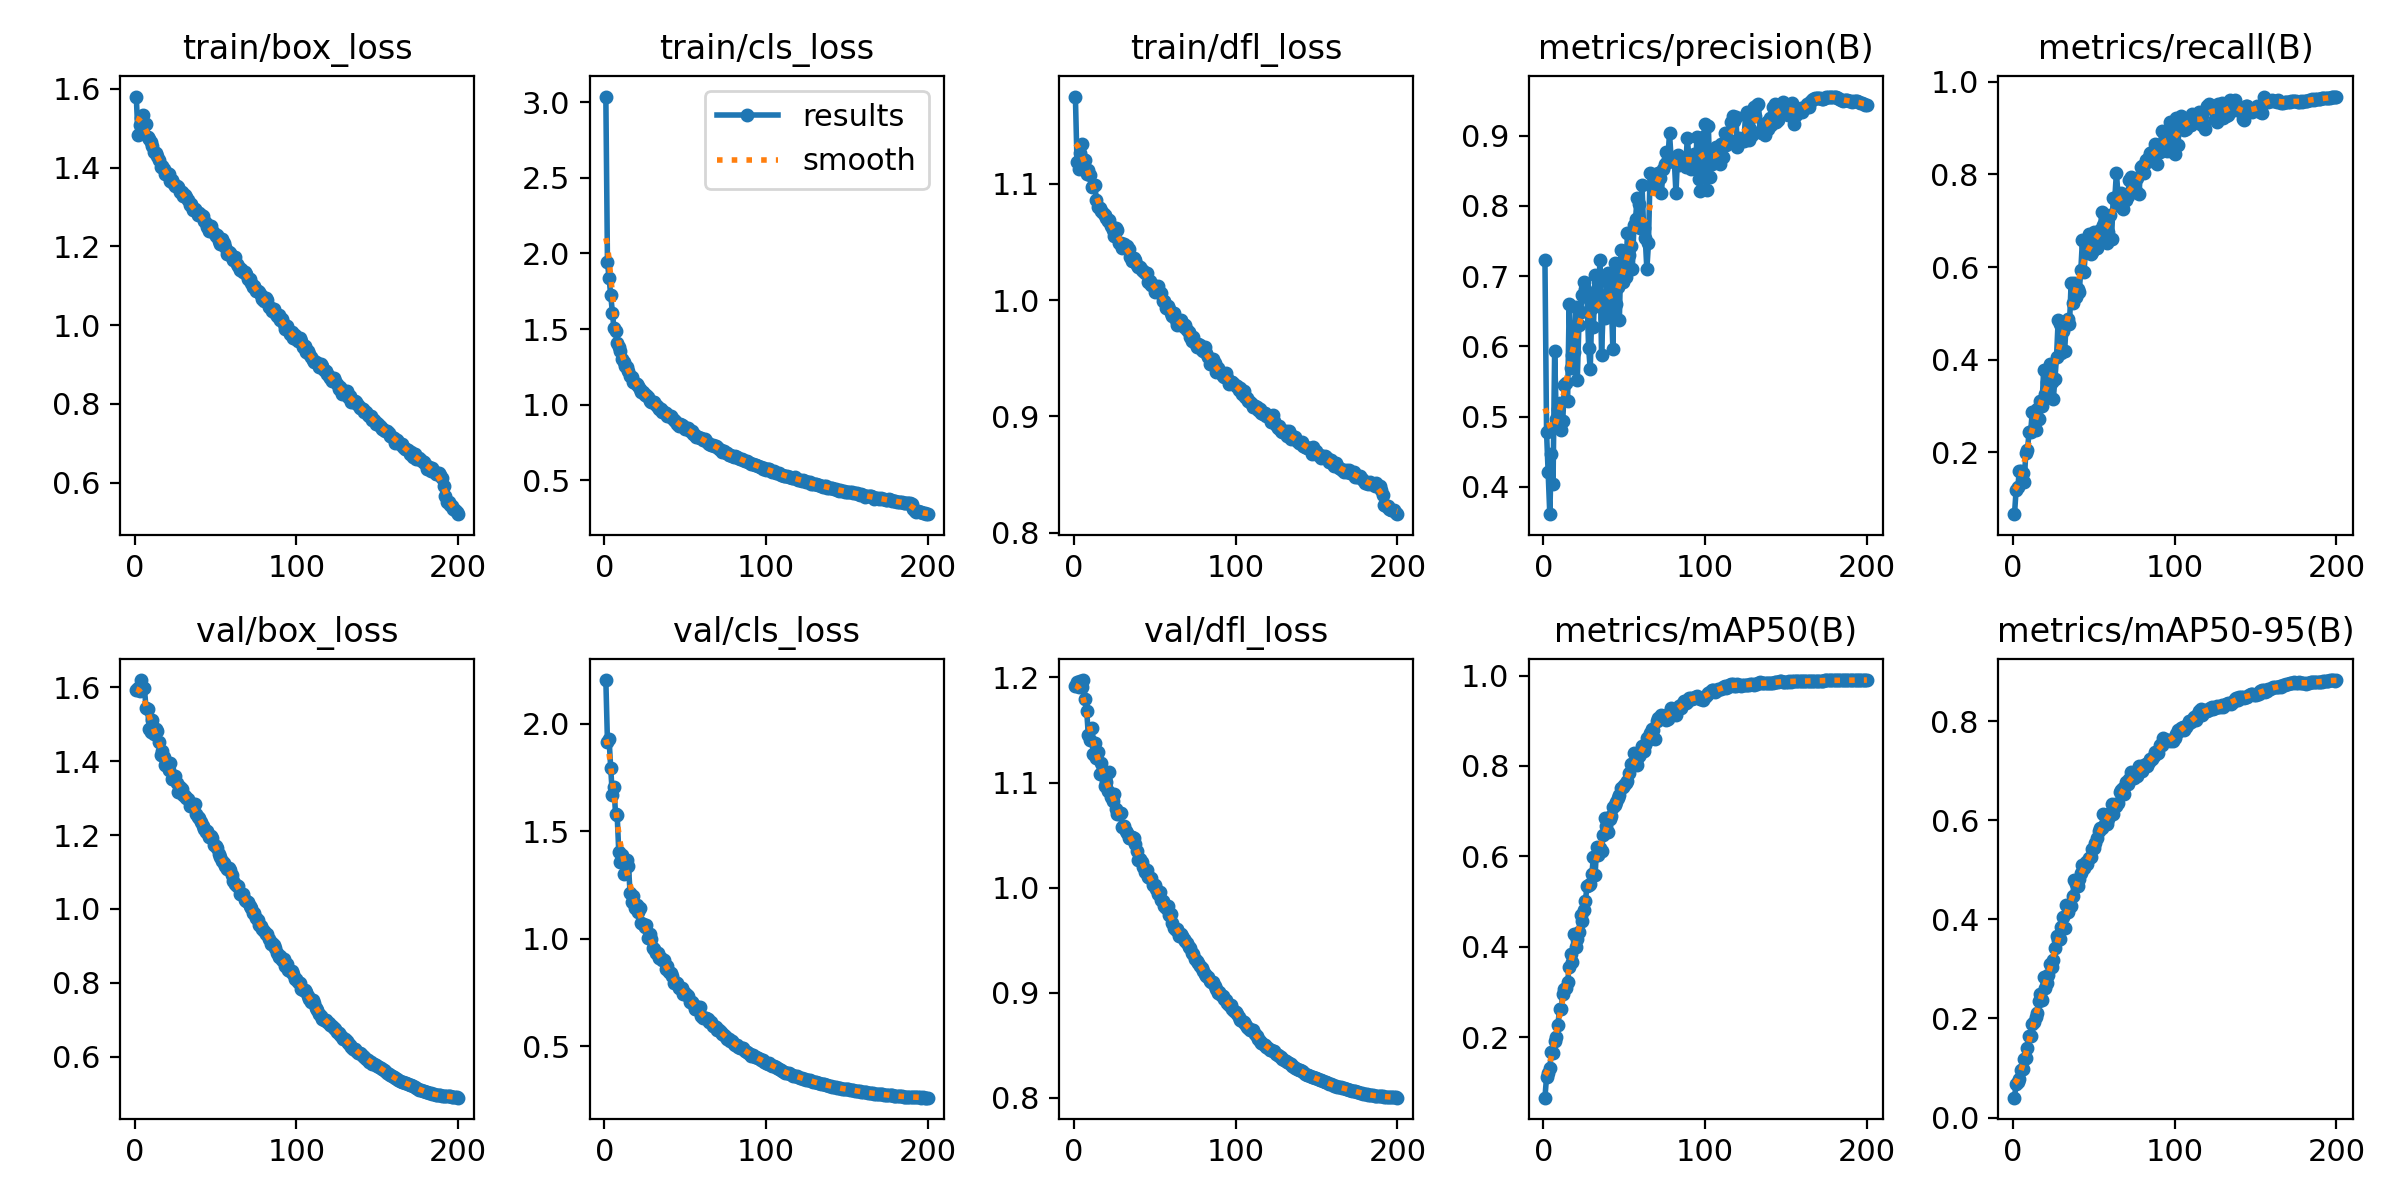

In [ ]:
from IPython.display import Image, display

# Display the results.png
file_path = os.path.join(save_dir, "results.png")
if os.path.exists(file_path):
    display(Image(filename=file_path, width=1000))
else:
    print("Image file not found.")

## Analysis of the Results:
From the above plots, we can tell that the loses and the evaluation metrics easily outperform the YOLOv8m baseline model trained on the same dataset for the same number of epochs.
1. The `mAP50` and `mAP50-95` range between 0.8 to 1.0 indicating that the model is doing an excellent job at object detection for the underwater images.
2. For the loss plots, the losses have dipped to around 0.5 to 0.8 while in the baseline, they teetered around 1.0 to 1.2, indicating that the model has done a better job with optimizing for the images than the baseline.

This highlights the significance of using the 80/20 split, showing improvement of around 20-40%.

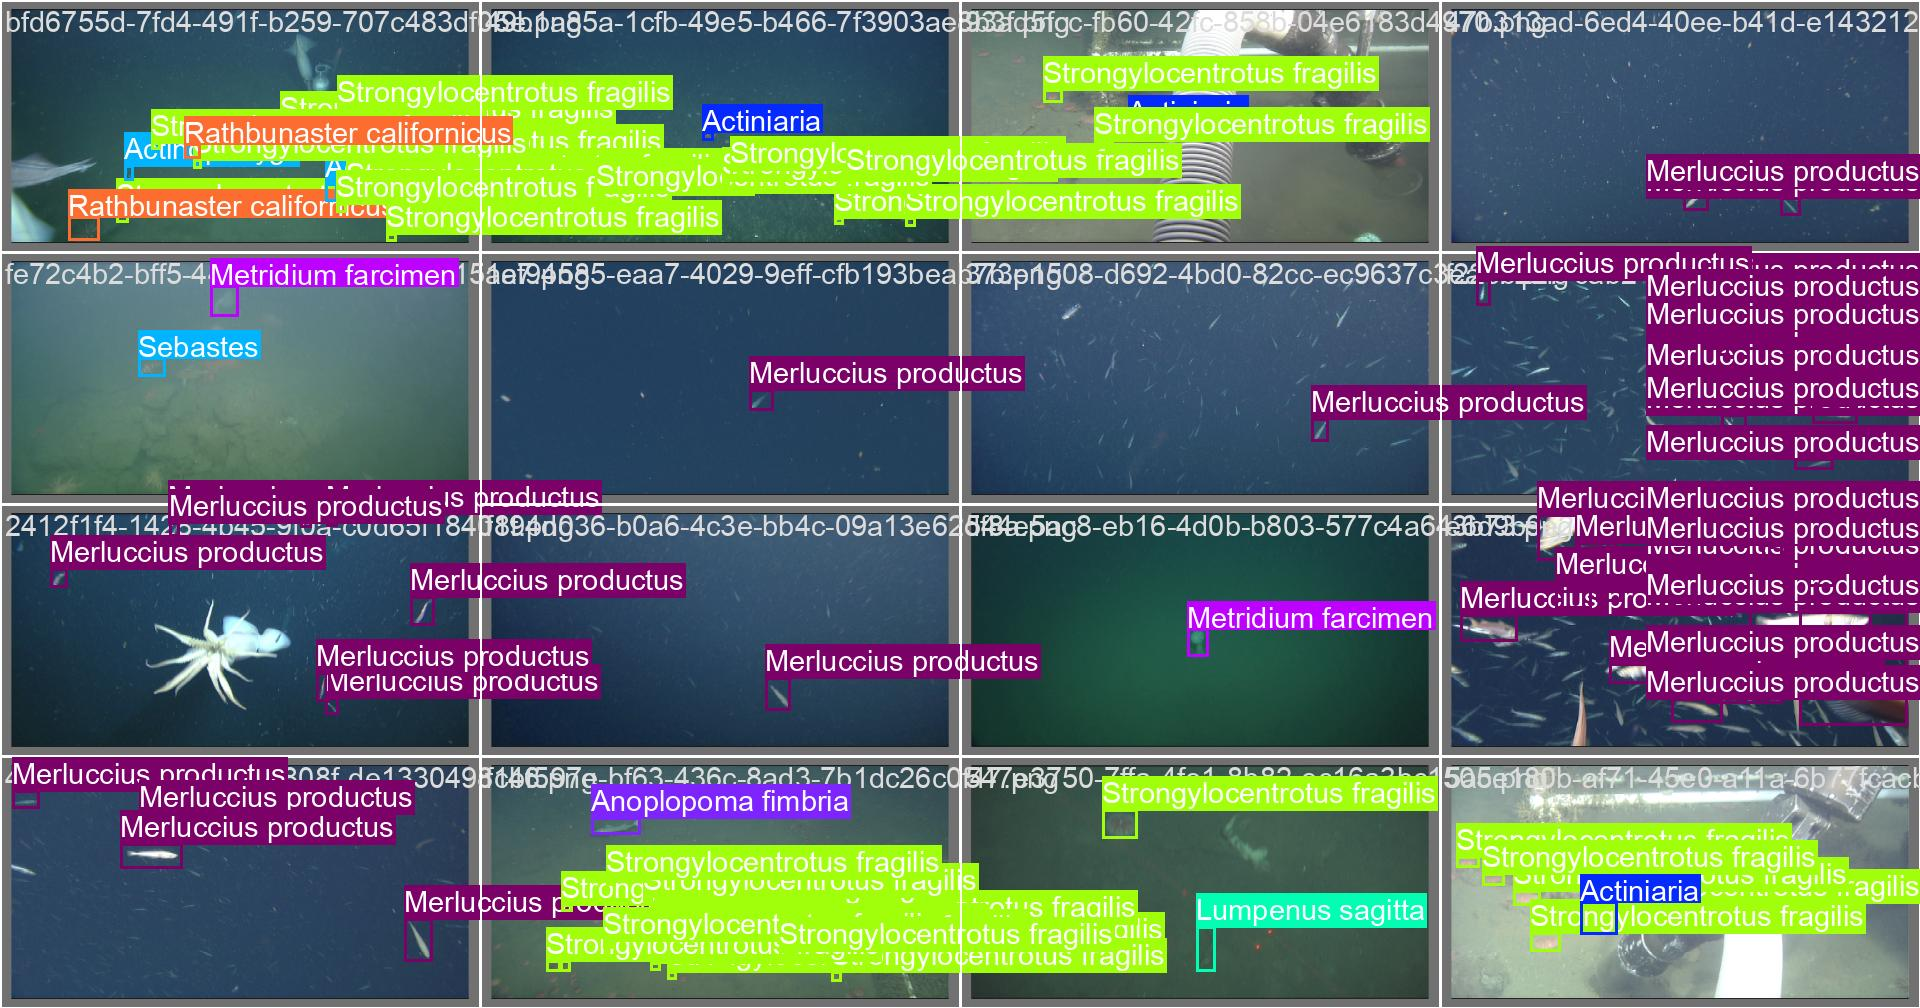

In [ ]:
file_path = os.path.join(save_dir,'val_batch0_labels.jpg')
Image(file_path, height=800, width=1200)

### Now we repeat the same on the resampled on an 80/20 split:


### Run on Larger YOLOv11L model

In [ ]:
# Load a pre-trained YOLOv11 model
model = YOLO("yolo11l.pt")

# Train the model
model.train(
    data="/content/drive/MyDrive/fathomnet-out-of-sample-detection/dataset.yaml",
    epochs=200,
    patience=40,               # Stop if no improvement for 40 epochs (early stopping)
    batch=16,
    imgsz=640,
    name='yolo11l_resampled',
    project = output_folder,
    save=True,
    verbose=False
)

100%|██████████| 49.0M/49.0M [00:00<00:00, 87.8MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/fathomnet-out-of-sample-detection/dataset.yaml, epochs=200, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs, name=yolo11l_resampled, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/train/labels.cache... 4760 images, 0 backgrounds, 1 corrupt: 100%|██████████| 4760/4760 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/fathomnet-out-of-sample-detection/train/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0446      1.0257]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/val/labels.cache... 1190 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1190/1190 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      12.5G      1.539      2.743      1.162         94        640: 100%|██████████| 298/298 [01:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


                   all       1190       6101      0.713     0.0901     0.0802     0.0498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      12.4G      1.504      1.944      1.123         61        640: 100%|██████████| 298/298 [01:12<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


                   all       1190       6101        0.5     0.0854     0.0768     0.0436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      12.4G      1.566      1.959      1.131         66        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


                   all       1190       6101      0.478     0.0984      0.083     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      12.2G      1.588      1.909      1.156         91        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.381     0.0844     0.0686     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      12.5G      1.582      1.716       1.16         45        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


                   all       1190       6101      0.462       0.12      0.106     0.0581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      12.5G      1.552      1.614      1.146         37        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.81it/s]


                   all       1190       6101      0.455      0.146      0.154     0.0906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      12.5G      1.546      1.567      1.143         42        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.446      0.145      0.146     0.0849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      12.5G      1.508      1.476      1.133         43        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.432      0.193      0.172      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      12.5G        1.5      1.452      1.128         86        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


                   all       1190       6101      0.497      0.131      0.171      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      12.4G      1.498      1.443      1.129         46        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


                   all       1190       6101      0.517      0.199      0.199      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      12.6G      1.483      1.379      1.117         26        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


                   all       1190       6101      0.528      0.192      0.224      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      12.5G      1.466      1.355      1.122         57        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


                   all       1190       6101      0.466      0.237       0.23      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      12.5G      1.464      1.333      1.121         26        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.519      0.168      0.209      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      12.2G      1.455      1.306       1.11         38        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.466      0.249      0.277       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      12.3G      1.446      1.284      1.101         41        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


                   all       1190       6101      0.555      0.243      0.297      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      12.1G      1.428      1.251      1.099         30        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.606      0.212      0.296       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      12.4G      1.425      1.244      1.095         68        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.644      0.211      0.327       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      12.2G       1.42      1.219      1.092         24        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


                   all       1190       6101      0.587      0.237      0.278      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      12.4G      1.411        1.2      1.093         35        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.583       0.28      0.347      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      12.4G      1.411        1.2      1.088         65        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.572      0.309       0.37      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      12.5G      1.406       1.19      1.084         16        640: 100%|██████████| 298/298 [01:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


                   all       1190       6101      0.607       0.33      0.406      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      12.4G      1.392      1.165      1.084         54        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.649      0.293      0.425      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      12.5G      1.396      1.149      1.081         77        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


                   all       1190       6101      0.667      0.285      0.393      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      12.4G      1.388       1.15      1.075         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.618      0.331       0.39      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      12.5G      1.384      1.125      1.074         51        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


                   all       1190       6101      0.643      0.333      0.404      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      12.4G      1.384      1.126      1.079         73        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.581      0.359      0.417      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      12.4G      1.378      1.117      1.078         26        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.82it/s]


                   all       1190       6101      0.603      0.347      0.421      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      12.5G       1.37      1.094      1.068         41        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


                   all       1190       6101      0.603      0.381      0.453      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      12.5G      1.366      1.087      1.066         50        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.651      0.328      0.453      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      12.1G      1.361      1.081      1.064         55        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.651      0.407      0.528      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      12.5G      1.361      1.081      1.068         91        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.666      0.357      0.483      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      12.3G      1.359      1.065      1.064         81        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


                   all       1190       6101      0.704      0.347      0.516      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      12.4G      1.354      1.051       1.07         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


                   all       1190       6101      0.628      0.414        0.5      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      12.4G      1.341      1.037      1.067         30        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


                   all       1190       6101      0.642      0.394      0.529      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      12.4G      1.345      1.049      1.059         35        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101       0.67      0.401      0.527      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      12.5G      1.336      1.022      1.058         54        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.614       0.46      0.544      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      12.4G      1.335       1.02      1.059         28        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.615      0.435      0.555      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      12.2G       1.33      1.015      1.056         28        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.629       0.43      0.536      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      12.4G      1.322     0.9951      1.052         51        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.745      0.423      0.584      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      12.5G      1.322     0.9935      1.048         62        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.567      0.535      0.614      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      12.4G      1.326      1.004      1.055         46        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.674      0.466      0.617      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      12.4G      1.319     0.9822      1.051         46        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


                   all       1190       6101       0.59      0.547      0.639      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      12.5G       1.31     0.9761       1.05         58        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


                   all       1190       6101      0.566      0.563      0.624      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      12.4G      1.304     0.9587      1.046         43        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


                   all       1190       6101      0.766       0.47      0.655      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      12.5G      1.299      0.955      1.048         48        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.655      0.582      0.675      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      12.4G      1.294     0.9407      1.045         48        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


                   all       1190       6101      0.678      0.531      0.659      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      12.4G      1.302     0.9457      1.042         59        640: 100%|██████████| 298/298 [01:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.598      0.591       0.67      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      12.4G      1.297     0.9407      1.043         61        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


                   all       1190       6101      0.721      0.531      0.692      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      12.4G       1.29     0.9338      1.039         34        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.754      0.539      0.702      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      12.5G      1.282     0.9165      1.036         43        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101       0.75      0.535      0.672      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      12.5G      1.287     0.9167      1.034         89        640: 100%|██████████| 298/298 [01:11<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


                   all       1190       6101      0.669       0.55      0.686      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      12.4G      1.278     0.9313      1.039         70        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


                   all       1190       6101      0.615      0.628      0.705      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      12.5G      1.261     0.9012       1.03         51        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


                   all       1190       6101      0.786      0.525      0.694      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      12.1G      1.276     0.9022      1.031         34        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.651      0.623      0.752      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      12.4G      1.276     0.8876       1.03        133        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.672      0.627      0.731      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      12.5G      1.266     0.8853      1.029         97        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.81it/s]


                   all       1190       6101      0.685      0.606      0.742      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      12.6G      1.246     0.8704      1.023         63        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.782      0.596      0.756      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      12.5G      1.253     0.8712      1.023         59        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.766      0.622      0.766      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      12.5G      1.256     0.8626      1.021         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


                   all       1190       6101      0.738      0.636      0.777       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      12.5G      1.239       0.86      1.015         31        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.787      0.625      0.777      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      12.5G      1.237     0.8454      1.017         48        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.736      0.669      0.775      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      12.5G      1.247     0.8554       1.02         46        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101       0.77      0.644      0.787      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      12.4G      1.229     0.8411      1.016         76        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.701      0.671      0.794      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      12.4G      1.226     0.8325      1.012         53        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101       0.78      0.671       0.82      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      12.5G      1.217     0.8213      1.011         41        640: 100%|██████████| 298/298 [01:11<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.773      0.678      0.808      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      12.5G       1.22      0.815      1.015         50        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101       0.84      0.627      0.811      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      12.5G      1.213     0.8194      1.013         70        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.698      0.748       0.82      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      12.5G      1.214     0.8142       1.01         48        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.722      0.713      0.807      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      12.5G      1.208      0.805       1.01         40        640: 100%|██████████| 298/298 [01:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.652       0.76      0.819        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      12.5G      1.198     0.8012      1.007         32        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101      0.759      0.717      0.829      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      12.3G      1.199     0.7946      1.007         25        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.804        0.7      0.823      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      12.4G      1.194     0.7853      1.002         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.793      0.707      0.835      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      12.5G      1.181     0.7739     0.9971         60        640: 100%|██████████| 298/298 [01:08<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


                   all       1190       6101      0.815      0.719      0.843      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      12.2G      1.186       0.78      1.004         79        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.703      0.778      0.843      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      12.4G      1.169     0.7691     0.9959         52        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.729      0.774       0.85      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      12.2G      1.173     0.7666     0.9947         51        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.815      0.721      0.856      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      12.5G      1.171     0.7569     0.9958         66        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.707      0.795       0.86      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      12.5G      1.165     0.7523     0.9947         90        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.807       0.76       0.89      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      12.4G      1.154      0.742     0.9905         35        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


                   all       1190       6101      0.824      0.766      0.877      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      12.2G      1.152     0.7426     0.9895         39        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


                   all       1190       6101       0.85      0.753      0.872      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      12.4G      1.156     0.7379     0.9944         47        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.813      0.767      0.882      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      12.5G      1.144     0.7343     0.9864         73        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.804      0.807      0.899      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      12.4G      1.139     0.7287      0.986         42        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.802      0.817      0.896      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      12.4G      1.139     0.7197     0.9787         78        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.779      0.833      0.911      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      12.4G      1.128     0.7281     0.9795         45        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101      0.748       0.87      0.915      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      12.4G      1.127     0.7116     0.9802         53        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


                   all       1190       6101      0.803      0.823      0.914      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      12.5G      1.121     0.7157     0.9801         42        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


                   all       1190       6101      0.792      0.855      0.913      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      12.2G      1.119       0.71     0.9719         49        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


                   all       1190       6101      0.837      0.829      0.919      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      12.5G      1.113     0.7022     0.9737         52        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


                   all       1190       6101      0.834      0.822      0.922      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      12.2G       1.11     0.6942     0.9718         46        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


                   all       1190       6101      0.878      0.805      0.927      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      12.4G      1.105     0.6892     0.9698         56        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.841        0.8      0.923      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      12.2G      1.097     0.6867     0.9693         58        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.814      0.878       0.93      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      12.4G      1.078     0.6782     0.9675         81        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101       0.79      0.873      0.933      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      12.5G      1.087     0.6789     0.9696         44        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


                   all       1190       6101       0.87      0.845      0.935       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      12.1G      1.081     0.6701     0.9671         59        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


                   all       1190       6101      0.802      0.876      0.933      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      12.4G      1.073      0.663     0.9631         41        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101      0.772      0.905      0.934      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      12.5G       1.07     0.6637     0.9604         58        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.824      0.897      0.938      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      12.5G      1.058     0.6491      0.962         59        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101      0.821      0.873      0.936      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      12.4G      1.061     0.6495     0.9582         46        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.841      0.888       0.94      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      12.2G      1.048     0.6412     0.9562         40        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.832      0.884      0.943       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      12.4G      1.052     0.6484     0.9586         74        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101       0.86      0.876      0.946      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      12.2G      1.053     0.6395     0.9533         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


                   all       1190       6101      0.879      0.862      0.949      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      12.4G      1.044      0.634     0.9548         41        640: 100%|██████████| 298/298 [01:11<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.825      0.905      0.946       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      12.4G      1.029     0.6246     0.9472         35        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.888      0.862      0.949      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      12.5G      1.033      0.633     0.9517         49        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.892      0.876      0.947      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      12.4G      1.018     0.6193     0.9469         36        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101      0.796      0.942      0.952      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      12.4G      1.024     0.6229     0.9473         38        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.865      0.896      0.954      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      12.4G      1.014     0.6139      0.942         47        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.902      0.882      0.958      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      12.4G      1.005     0.6072     0.9405         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.863      0.914      0.964      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      12.4G     0.9949     0.6063     0.9379         62        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.855      0.917      0.959      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      12.4G     0.9961     0.5993     0.9368         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.896      0.884      0.963      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      12.2G      0.987     0.5903     0.9348         45        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.907      0.891      0.957      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      12.4G     0.9819     0.5965     0.9333         37        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


                   all       1190       6101      0.885      0.903      0.964      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      12.4G      0.972     0.5831     0.9319         61        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


                   all       1190       6101      0.877      0.924      0.967      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      12.5G     0.9792     0.5853     0.9319         86        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


                   all       1190       6101      0.889      0.928      0.968      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      12.4G     0.9726     0.5826     0.9283         32        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.896      0.931      0.968      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      12.4G     0.9617     0.5761     0.9272         55        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101      0.898      0.929      0.967      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      12.5G     0.9571     0.5767     0.9268         31        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.85it/s]


                   all       1190       6101       0.93      0.908       0.97      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      12.4G     0.9561     0.5677     0.9274         58        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


                   all       1190       6101      0.921      0.915      0.969      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      12.2G     0.9489     0.5663      0.926         36        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.901      0.947      0.968       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      12.4G     0.9452     0.5644     0.9238         76        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.924      0.938      0.967      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      12.5G     0.9329     0.5548     0.9194         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.916      0.936      0.967       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      12.5G     0.9359     0.5536     0.9253         48        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


                   all       1190       6101      0.921      0.931       0.97      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      12.5G     0.9313     0.5485     0.9172         33        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


                   all       1190       6101      0.907      0.939      0.973      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      12.4G     0.9242      0.544      0.915         69        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


                   all       1190       6101      0.931      0.915      0.972      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      12.1G     0.9119     0.5431      0.912         59        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.921      0.937      0.973      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      12.5G     0.9135     0.5405      0.914         73        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


                   all       1190       6101      0.929       0.93      0.973      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      12.5G     0.8957     0.5281     0.9088         63        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.931      0.937      0.973       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      12.4G     0.9016     0.5316      0.911         95        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.926      0.938      0.973       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      12.5G     0.9013     0.5287     0.9086         43        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


                   all       1190       6101      0.915      0.944      0.974      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      12.5G     0.9012     0.5268     0.9098         61        640: 100%|██████████| 298/298 [01:09<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.935      0.917      0.973      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      12.4G     0.8869     0.5218      0.906         55        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.931      0.922      0.976      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      12.4G     0.8847     0.5176     0.9066         93        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.938      0.918      0.976      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      12.3G     0.8713     0.5162     0.9017         61        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.927      0.923      0.976      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      12.4G     0.8713     0.5098     0.9054         33        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.932      0.923      0.976      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      12.5G     0.8682     0.5134     0.9034         60        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


                   all       1190       6101      0.932      0.928      0.977      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      12.4G      0.861     0.5072     0.9005         30        640: 100%|██████████| 298/298 [01:09<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.935      0.926      0.976      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      12.4G     0.8574     0.4979     0.8986         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


                   all       1190       6101      0.933      0.928      0.977       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      12.2G     0.8498     0.4958     0.8958         31        640: 100%|██████████| 298/298 [01:11<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


                   all       1190       6101      0.938      0.928      0.976      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      12.5G     0.8479     0.4929     0.8967         41        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


                   all       1190       6101      0.938      0.928      0.977      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      12.4G     0.8461     0.4953     0.8958         42        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


                   all       1190       6101      0.935      0.933      0.977      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      12.4G     0.8375     0.4849      0.892         50        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.939       0.93      0.978      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      12.4G     0.8316     0.4899      0.891         96        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101      0.945      0.923      0.978      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      12.4G     0.8265     0.4816     0.8897         34        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


                   all       1190       6101      0.936      0.932      0.978      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      12.4G     0.8243     0.4748     0.8916         88        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.934      0.932      0.977      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      12.5G     0.8206     0.4793     0.8908         23        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101       0.93      0.934      0.976      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      12.4G     0.8131     0.4763     0.8857         41        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.931      0.937      0.978       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      12.4G     0.8084     0.4711     0.8901         44        640: 100%|██████████| 298/298 [01:11<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.937      0.931      0.979      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      12.5G     0.8036     0.4675     0.8867         44        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101      0.939       0.93      0.979      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      12.4G     0.8027     0.4624     0.8853         85        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


                   all       1190       6101      0.932       0.94      0.979      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      12.5G     0.7989     0.4663      0.882         34        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


                   all       1190       6101      0.933      0.939       0.98      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      12.4G     0.7854     0.4562     0.8806         60        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


                   all       1190       6101      0.939      0.934       0.98      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      12.5G     0.7896     0.4595     0.8795         70        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101      0.912      0.962       0.98      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      12.4G     0.7765     0.4497     0.8794         20        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


                   all       1190       6101      0.928      0.953       0.98      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      12.5G     0.7791     0.4532     0.8798         46        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.939       0.95      0.981      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      12.5G     0.7768     0.4498     0.8794         61        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


                   all       1190       6101      0.946      0.945      0.981      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      12.5G     0.7689     0.4457     0.8776         57        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.948      0.942      0.979      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      12.5G     0.7638      0.442     0.8759         35        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.947      0.941      0.979      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      12.5G     0.7634     0.4423     0.8766         54        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


                   all       1190       6101      0.949      0.944      0.981      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      12.3G     0.7567     0.4388      0.873         50        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


                   all       1190       6101       0.95      0.944      0.981      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      12.3G     0.7433     0.4296     0.8719         68        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101      0.951      0.946      0.981      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      12.2G     0.7508     0.4332     0.8728         81        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.951      0.946      0.981      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      12.5G      0.745     0.4279     0.8696         58        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101      0.952      0.948      0.981      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      12.4G     0.7346     0.4273     0.8689         55        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


                   all       1190       6101      0.952      0.948      0.981       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      12.4G      0.739     0.4261     0.8686         49        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.953      0.948      0.981      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      12.4G     0.7254     0.4193      0.865         29        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.953      0.948      0.981      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      12.5G     0.7218     0.4115     0.8633         90        640: 100%|██████████| 298/298 [01:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.952       0.95      0.982      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      12.2G     0.7236     0.4149     0.8646         69        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.948      0.953      0.981      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      12.5G     0.7198     0.4158     0.8649         39        640: 100%|██████████| 298/298 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


                   all       1190       6101      0.949      0.953      0.982      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      12.4G     0.7064     0.4073     0.8654         34        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.948      0.953      0.982      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      12.5G     0.7091     0.4112     0.8608         88        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.949      0.953      0.982      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      12.4G     0.6989     0.4049     0.8628         22        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


                   all       1190       6101       0.95      0.953      0.982       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      12.4G     0.7006     0.4054     0.8627         64        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


                   all       1190       6101      0.951      0.953      0.982       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      12.5G     0.6943      0.399     0.8591         78        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.946      0.956      0.982      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      12.5G     0.6909        0.4     0.8575         34        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


                   all       1190       6101      0.945      0.957      0.982      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      12.2G     0.6909     0.4006      0.859         81        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101      0.946      0.957      0.982      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      12.4G     0.6848     0.3967     0.8586         54        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101       0.95      0.956      0.982      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      12.4G     0.6847     0.3926      0.856         20        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.951      0.954      0.982      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      12.5G     0.6805     0.3912     0.8542         48        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101       0.95      0.955      0.982      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      12.2G     0.6716     0.3842     0.8529         52        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101       0.95      0.955      0.982      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      12.3G     0.6633     0.3819     0.8513         50        640: 100%|██████████| 298/298 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


                   all       1190       6101       0.95      0.955      0.982      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      12.5G     0.6672     0.3838     0.8513         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


                   all       1190       6101      0.951      0.955      0.983      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      12.5G     0.6527     0.3779     0.8526         36        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


                   all       1190       6101       0.95      0.956      0.983      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      12.5G     0.6591     0.3815     0.8511         46        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


                   all       1190       6101      0.951      0.956      0.983      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      12.5G     0.6525     0.3748     0.8498         55        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


                   all       1190       6101      0.951      0.957      0.983      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      12.4G     0.6483     0.3732     0.8485         77        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.951      0.957      0.983      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      12.5G     0.6451     0.3718     0.8503         36        640: 100%|██████████| 298/298 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.951      0.958      0.983      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      12.4G     0.6485     0.3716     0.8484         49        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


                   all       1190       6101       0.95      0.959      0.983       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      12.4G     0.6437     0.3711     0.8488         59        640: 100%|██████████| 298/298 [01:11<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


                   all       1190       6101      0.951      0.959      0.983      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      12.2G     0.6384     0.3665     0.8456         39        640: 100%|██████████| 298/298 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


                   all       1190       6101       0.95      0.959      0.983      0.891
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      12.4G      0.614     0.3341      0.842         31        640: 100%|██████████| 298/298 [01:11<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


                   all       1190       6101      0.951      0.959      0.983       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      12.4G     0.5879     0.3194     0.8321         17        640: 100%|██████████| 298/298 [01:09<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


                   all       1190       6101      0.952      0.958      0.983      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      12.4G     0.5717     0.3136     0.8312         59        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


                   all       1190       6101      0.953      0.958      0.983      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      12.4G     0.5723     0.3159     0.8303         16        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


                   all       1190       6101      0.953      0.957      0.983      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      12.4G     0.5668     0.3115     0.8288         17        640: 100%|██████████| 298/298 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


                   all       1190       6101      0.953      0.957      0.983      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      12.4G     0.5651      0.311     0.8291         21        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


                   all       1190       6101      0.953      0.958      0.983      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      12.5G     0.5538     0.3038     0.8281         21        640: 100%|██████████| 298/298 [01:09<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


                   all       1190       6101      0.953      0.958      0.984      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      12.4G     0.5488     0.3019     0.8267         57        640: 100%|██████████| 298/298 [01:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


                   all       1190       6101      0.954      0.957      0.984      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      12.3G     0.5483     0.3022     0.8254         19        640: 100%|██████████| 298/298 [01:09<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


                   all       1190       6101      0.954      0.957      0.984      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      12.5G     0.5364     0.2961     0.8235         44        640: 100%|██████████| 298/298 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


                   all       1190       6101      0.954      0.957      0.984      0.897

200 epochs completed in 4.462 hours.
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled/weights/last.pt, 51.7MB
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled/weights/best.pt, 51.7MB

Validating /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11l summary (fused): 464 layers, 25,502,902 parameters, 0 gradients, 87.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.59it/s]


                   all       1190       6101      0.954      0.957      0.984      0.898
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  19,  21,  25,  26,  27,  28,  29,  34,  35,  36,  38,  42,  50,  51,  53,  60,  66,  68,  69,  74,  80,  81,  84,  85,  87,  89,  90,  92,  93,  95,  98,  99, 102, 103, 104, 106, 107, 109, 115, 116, 118, 119, 120, 123, 124, 130, 131, 132, 137, 141,
       145, 156, 159, 161, 165, 172, 173, 194, 200, 201, 202, 204, 205, 210, 213, 214, 217, 218, 219, 223, 225, 227, 228, 241, 242, 245, 254, 255, 258, 259, 264, 281])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d4a69051060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013

In [ ]:
# Directory path
save_dir = os.path.join(output_folder, 'yolo11l_resampled')

# List the contents
contents = os.listdir(save_dir)
print("Contents of the directory:")
for item in contents:
    print(item)

Contents of the directory:
weights
args.yaml
events.out.tfevents.1734671113.92baf55efb04.6837.2
labels_correlogram.jpg
labels.jpg
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
results.csv
train_batch56620.jpg
train_batch56621.jpg
train_batch56622.jpg
val_batch0_pred.jpg
val_batch0_labels.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_pred.jpg
val_batch2_labels.jpg
PR_curve.png
F1_curve.png
P_curve.png
R_curve.png
confusion_matrix_normalized.png
confusion_matrix.png
results.png


In [ ]:
pd.read_csv(os.path.join(save_dir, 'results.csv'))

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,96.9946,1.53937,2.74296,1.16215,0.71271,0.09014,0.08022,0.04981,1.58340,2.08448,1.23477,0.003322,0.003322,0.003322
1,2,179.9330,1.50381,1.94391,1.12281,0.49967,0.08537,0.07684,0.04363,1.70251,2.31780,1.27242,0.006623,0.006623,0.006623
2,3,260.0560,1.56587,1.95940,1.13145,0.47804,0.09844,0.08304,0.04926,1.67858,2.14931,1.24875,0.009890,0.009890,0.009890
3,4,339.9130,1.58827,1.90860,1.15609,0.38097,0.08441,0.06856,0.03791,1.70849,2.28323,1.24055,0.009851,0.009851,0.009851
4,5,419.3060,1.58200,1.71587,1.15989,0.46213,0.11961,0.10639,0.05813,1.75455,2.04906,1.28367,0.009802,0.009802,0.009802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,15738.0000,0.56514,0.31102,0.82913,0.95334,0.95758,0.98319,0.89491,0.47582,0.26788,0.80356,0.000347,0.000347,0.000347
196,197,15818.0000,0.55382,0.30382,0.82811,0.95330,0.95776,0.98351,0.89648,0.47420,0.26725,0.80322,0.000298,0.000298,0.000298
197,198,15898.5000,0.54876,0.30191,0.82665,0.95368,0.95732,0.98353,0.89617,0.47306,0.26666,0.80301,0.000249,0.000249,0.000249
198,199,15978.3000,0.54833,0.30220,0.82535,0.95403,0.95690,0.98357,0.89662,0.47190,0.26626,0.80277,0.000199,0.000199,0.000199


In [ ]:
file_path = os.path.join(save_dir, "results.png")

# Check if the file exists
if os.path.exists(file_path):
    print(f"'results.png' found at: {file_path}")
else:
    print("'results.png' not found. Check the directory or file path.")

'results.png' found at: /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolo11l_resampled/results.png


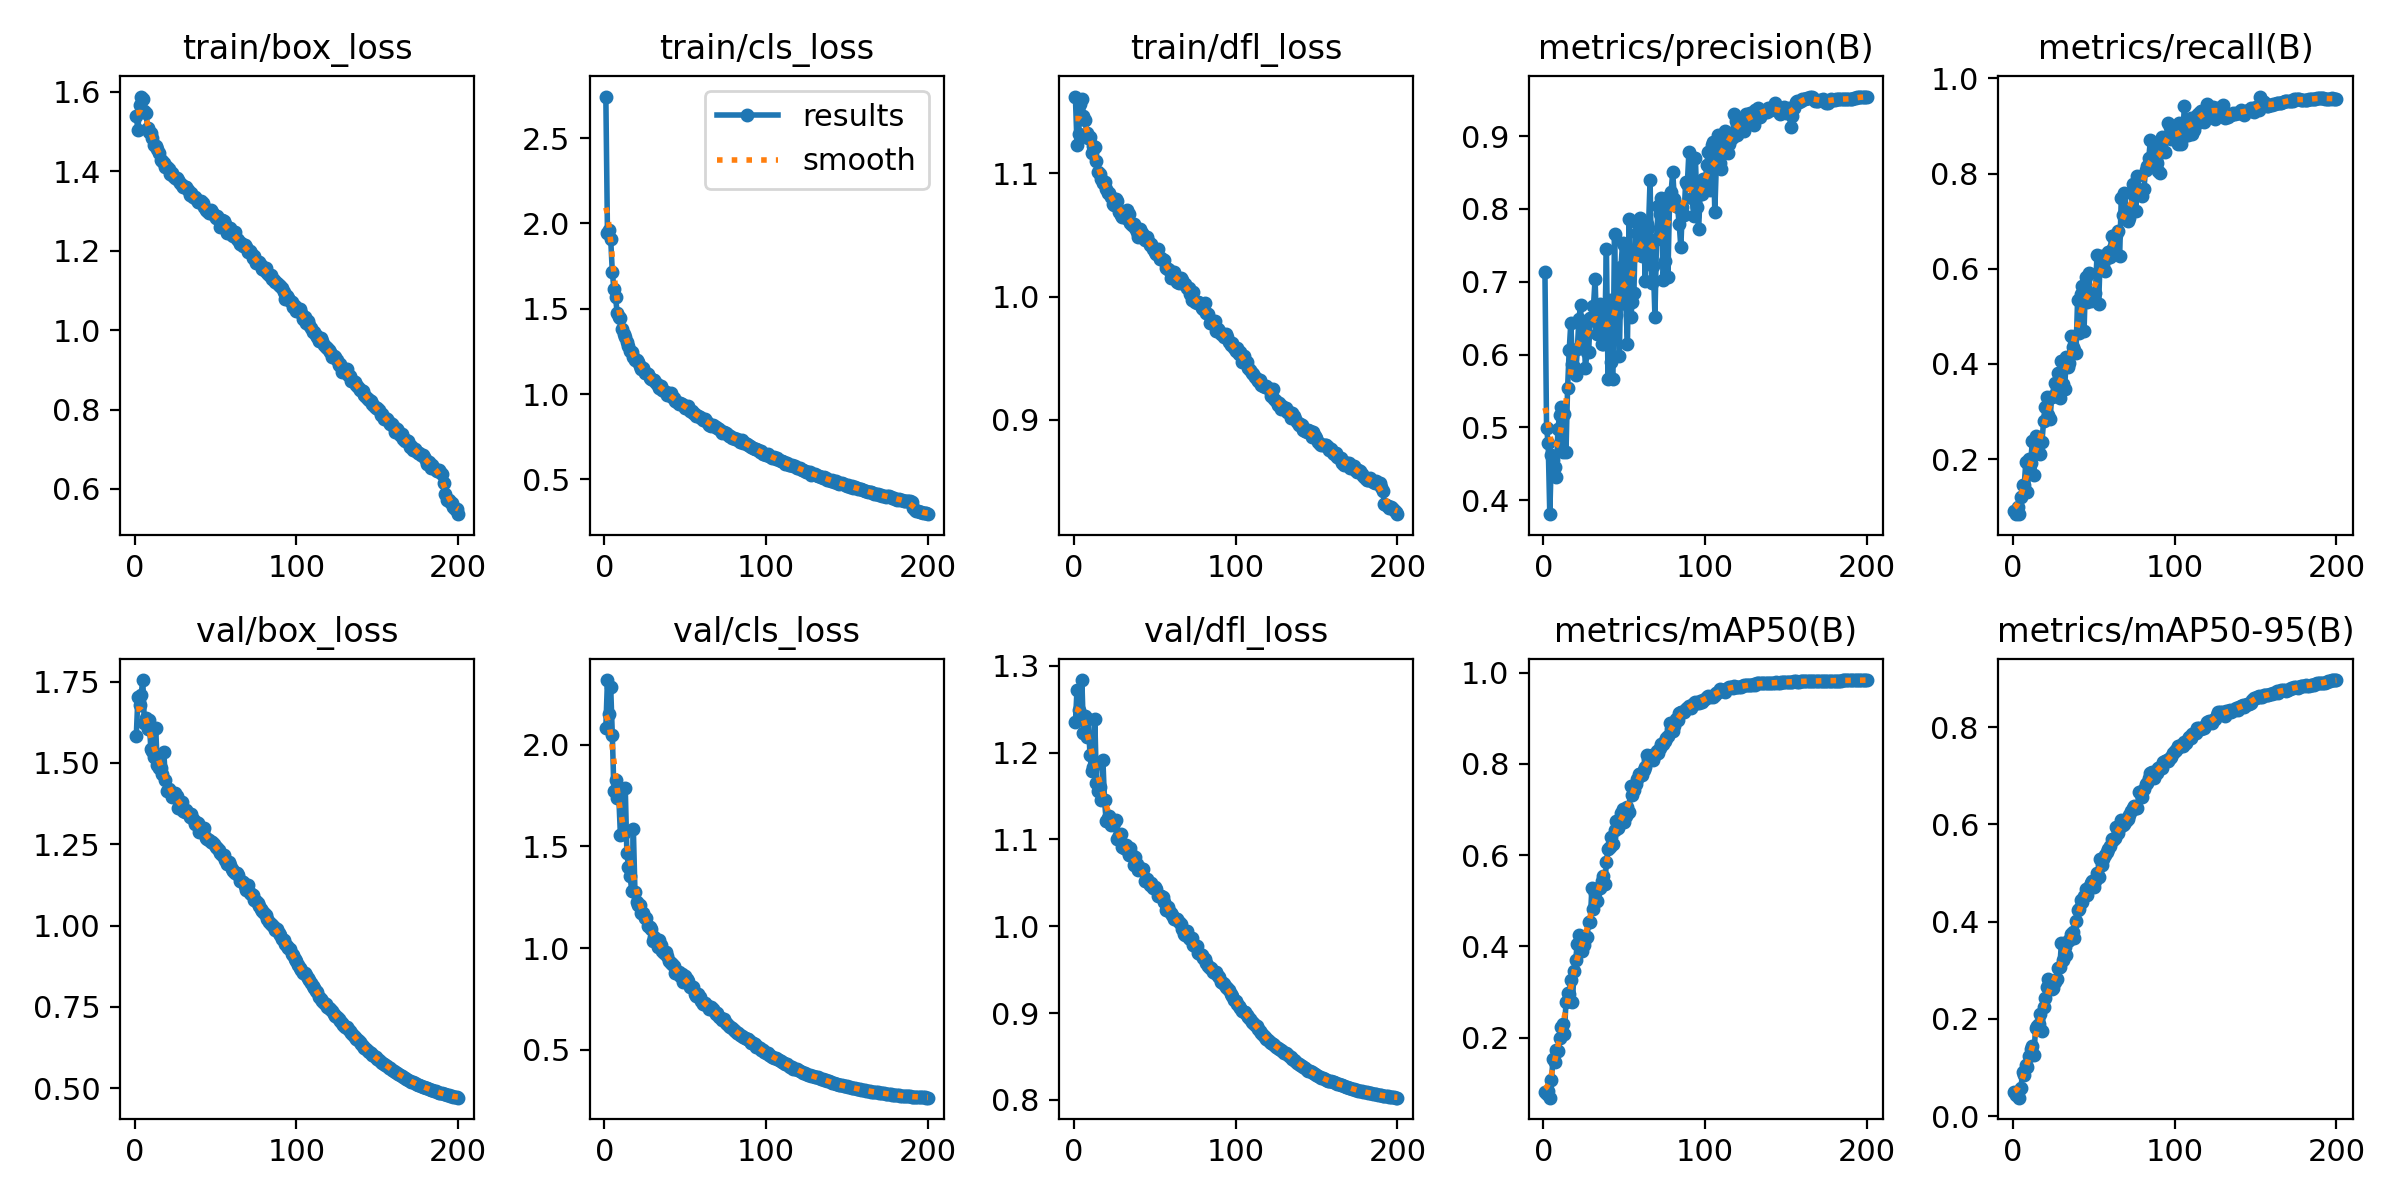

In [ ]:
from IPython.display import Image, display

# Display the results.png
file_path = os.path.join(save_dir, "results.png")
if os.path.exists(file_path):
    display(Image(filename=file_path, width=1000))
else:
    print("Image file not found.")

## Analysis of the Results:
From the above plots, we can tell that the loses and the evaluation metrics easily outperform the YOLOv8m baseline model trained on the same dataset for the same number of epochs.
1. The `mAP50` and `mAP50-95` range between 0.8 to 1.0 indicating that the model is doing an excellent job at object detection for the underwater images.
2. For the loss plots, the losses have dipped to around 0.5 to 0.8 while in the baseline, they teetered around 1.0 to 1.2, indicating that the model has done a better job with optimizing for the images than the baseline.

The results are similar to that of YOLOv8m and YOLOv11m on 80/20, so this highlights that there is not a need to use larger models since it attains simialr results.

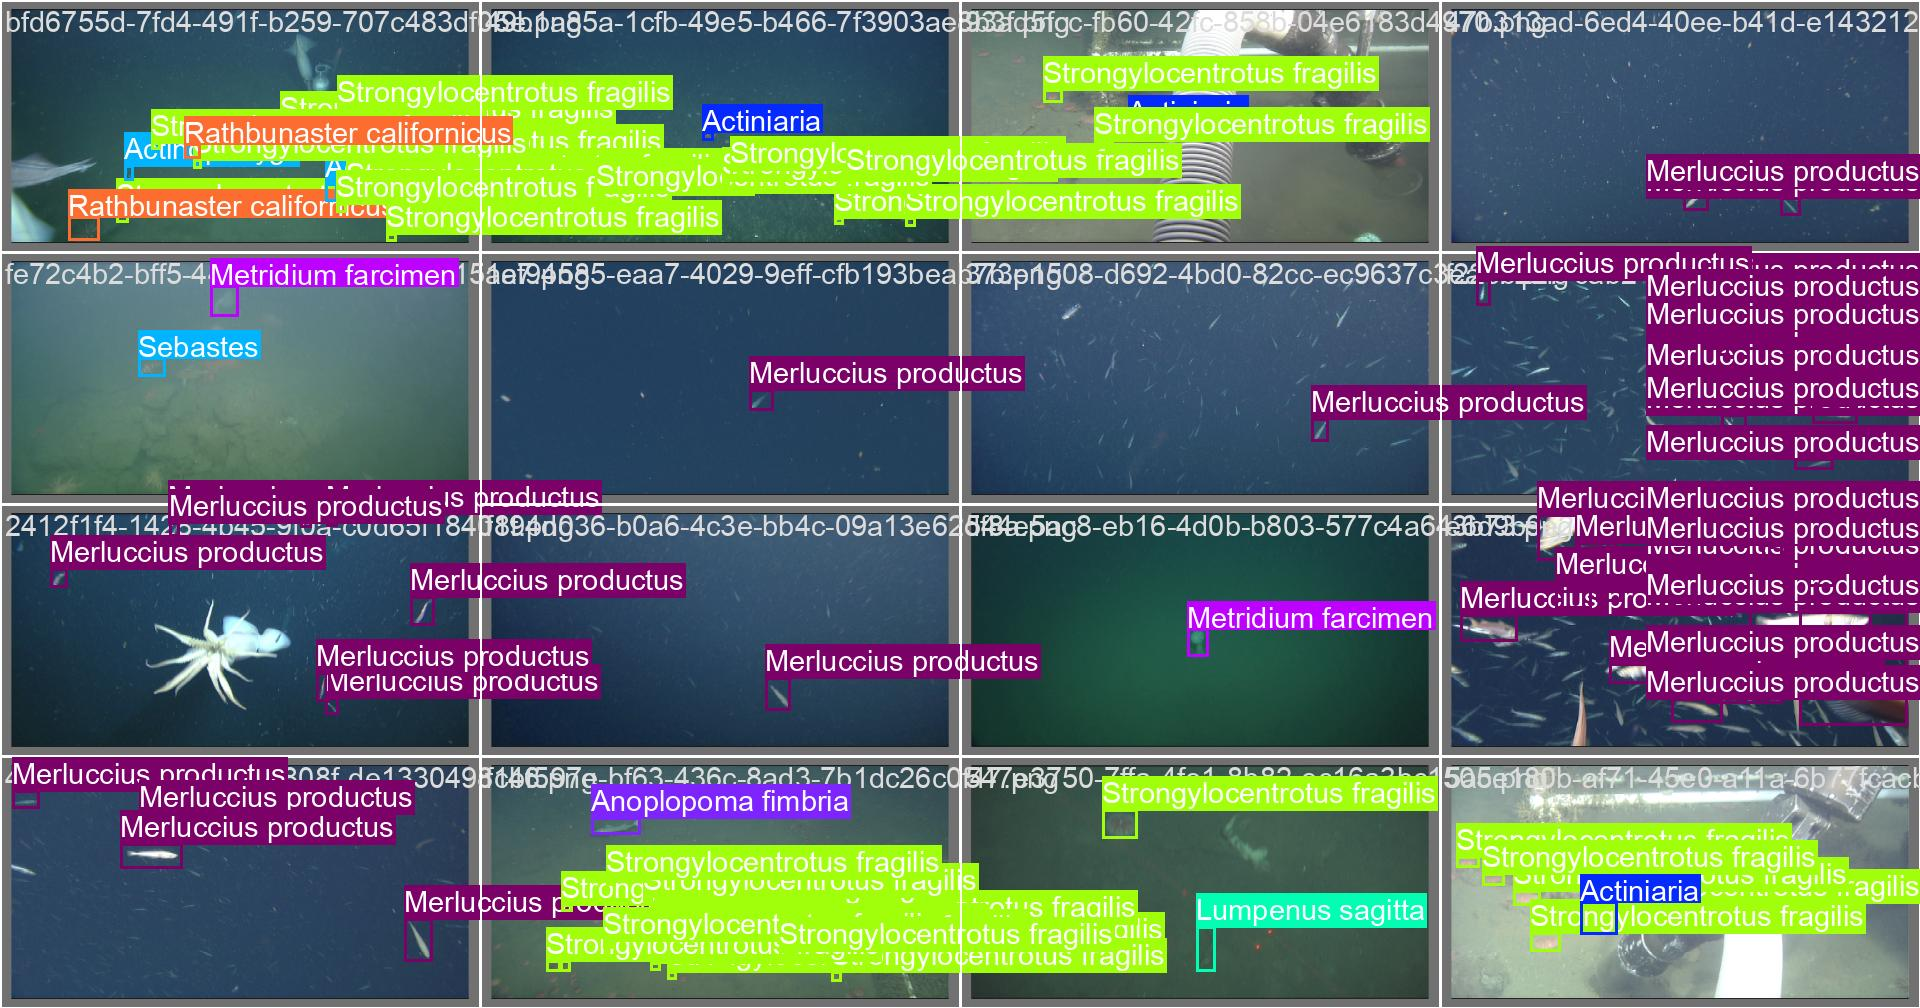

In [ ]:
file_path = os.path.join(save_dir,'val_batch0_labels.jpg')
Image(file_path, height=800, width=1200)